In [1]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.
1.15.2


In [2]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import math
import random

# read data from csv file and process X, y
def data_loader(data_path):
		# load raw data
		df = pd.read_csv(data_path)

		# clean data with missing values          
		'''drop the rows directly -> mess up the order
			first 24 rows have pm2.5 value that is NaN -> discard
			else: forward filling'''
		df = df[24:].fillna(method='ffill')

		# integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
		df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
		df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
		df = df.set_index('time')

		# expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
		df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
		del df['cbwd']

		# df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

		X = df.iloc[:,1:].astype(np.float32)
		y = df['pm2.5'].astype(np.float32).to_frame()
	
		return X, y
  
# Z-score normalisation
def data_normalisation(train, test):
		X_train, y_train = train[0], train[1]
		X_test, y_test = test[0], test[1]

		mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
		mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)
	
		# Use the mean & std of train. Since there's no way for us to know the future.
		# (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)
		(X_train, y_train) = ((X_train-mean_x)/std_x, np.log(np.asarray(y_train) + 1))
		(X_test, y_test) = ((X_test-mean_x)/std_x, np.log(np.asarray(y_test) + 1))
		# (X_train, y_train) = ((X_train-mean_x)/std_x, y_train)
		# (X_val, y_val) = ((X_val-mean_x)/std_x, y_val) 
		# (X_test, y_test) = ((X_test-mean_x)/std_x, y_test)

		return (X_train, y_train),(X_test, y_test)

data_path = "/content/drive/My Drive/Colab Notebooks/PM2dot5.csv"
X, y = data_loader(data_path)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.1, shuffle=True)

(X_train, y_train),(X_test, y_test) = data_normalisation((X_train, y_train),(X_test, y_test))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39420, 10), (39420, 1), (4380, 10), (4380, 1))

In [3]:
#Network parameters
n_input = 10 
n_hidden1, n_hidden2 = 20, 10
n_output = 1
#Learning parameters 
learning_rate = 0.00005
number_epochs = 20000
batch_size = 128

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input], name='X_p') 
Y_p = tf.placeholder("float", [None, n_output], name='Y_p')

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    # b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    # b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    b3 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    # w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    # w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_output]))

    layer_1 = tf.nn.leaky_relu(tf.add(tf.matmul(input_d, w1), b1), alpha=0.01) #Task of neurons of first hidden layer
    layer_2 = tf.nn.leaky_relu(tf.add(tf.matmul(layer_1, w2), b2), alpha=0.01) #Task of neurons of second hidden layer
    # layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, w3), b3)) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_2, w3),b3)            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)
# define loss function
loss_func = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p)) # MSE
eval_RMSE = tf.cast(tf.sqrt(loss_func),dtype=tf.float32)
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_func)

# initializaing variables
init = tf.global_variables_initializer()

Fold 1:
Epoch: 1000, Training loss: 6.557937, Validation loss: 7.8181925, 
Epoch: 2000, Training loss: 4.592772, Validation loss: 4.653705, 
Epoch: 3000, Training loss: 3.458156, Validation loss: 3.5212557, 
Epoch: 4000, Training loss: 3.1167905, Validation loss: 2.889822, 
Epoch: 5000, Training loss: 2.1075811, Validation loss: 2.4950218, 
Epoch: 6000, Training loss: 1.8544424, Validation loss: 2.222515, 
Epoch: 7000, Training loss: 1.5782815, Validation loss: 2.0124831, 
Epoch: 8000, Training loss: 2.2625804, Validation loss: 1.84444, 
Epoch: 9000, Training loss: 1.9942653, Validation loss: 1.7044137, 
Epoch: 10000, Training loss: 1.5159811, Validation loss: 1.5899351, 
Epoch: 11000, Training loss: 1.5689596, Validation loss: 1.4945426, 
Epoch: 12000, Training loss: 1.2942019, Validation loss: 1.4123204, 
Epoch: 13000, Training loss: 1.7246494, Validation loss: 1.3453474, 
Epoch: 14000, Training loss: 1.3439571, Validation loss: 1.2851952, 
Epoch: 15000, Training loss: 1.1885495, Val

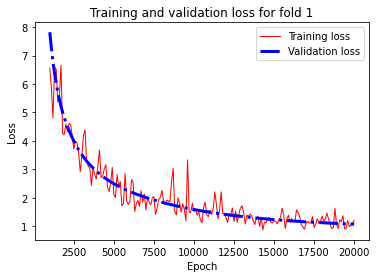

<Figure size 432x288 with 0 Axes>

Final Training loss: 1.213114, Final Validation loss: 1.0770983, RMSE: 1.0378335 
-----------------------------------------------------------------------


Fold 2:
Epoch: 1000, Training loss: 1.0283973, Validation loss: 1.0994558, 
Epoch: 2000, Training loss: 1.2014265, Validation loss: 1.0792786, 
Epoch: 3000, Training loss: 0.7846378, Validation loss: 1.0628784, 
Epoch: 4000, Training loss: 1.0629508, Validation loss: 1.0485966, 
Epoch: 5000, Training loss: 0.9789919, Validation loss: 1.0350118, 
Epoch: 6000, Training loss: 1.0611898, Validation loss: 1.021793, 
Epoch: 7000, Training loss: 0.862461, Validation loss: 1.0092902, 
Epoch: 8000, Training loss: 1.0118881, Validation loss: 0.99857485, 
Epoch: 9000, Training loss: 0.9982586, Validation loss: 0.98858887, 
Epoch: 10000, Training loss: 0.92963266, Validation loss: 0.9791015, 
Epoch: 11000, Training loss: 0.9670238, Validation loss: 0.97121173, 
Epoch: 12000, Training loss: 0.79831445, Validation loss: 0.9613603, 
Epoch: 13000, 

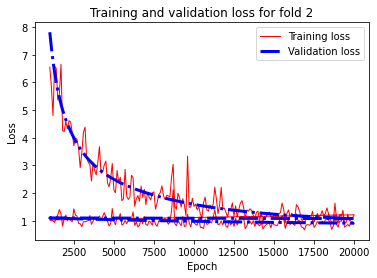

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.89735043, Final Validation loss: 0.9078682, RMSE: 0.9528212 
-----------------------------------------------------------------------


Fold 3:
Epoch: 1000, Training loss: 0.8940026, Validation loss: 0.8920238, 
Epoch: 2000, Training loss: 1.0347128, Validation loss: 0.8852445, 
Epoch: 3000, Training loss: 0.64035463, Validation loss: 0.8794978, 
Epoch: 4000, Training loss: 0.9007343, Validation loss: 0.87355936, 
Epoch: 5000, Training loss: 0.81696033, Validation loss: 0.8683709, 
Epoch: 6000, Training loss: 0.93660927, Validation loss: 0.86281466, 
Epoch: 7000, Training loss: 0.7824085, Validation loss: 0.85780764, 
Epoch: 8000, Training loss: 0.8497625, Validation loss: 0.85334885, 
Epoch: 9000, Training loss: 0.8001013, Validation loss: 0.84845144, 
Epoch: 10000, Training loss: 0.79240835, Validation loss: 0.8444302, 
Epoch: 11000, Training loss: 0.81353617, Validation loss: 0.84039533, 
Epoch: 12000, Training loss: 0.6880144, Validation loss: 0.8359019, 
Epoc

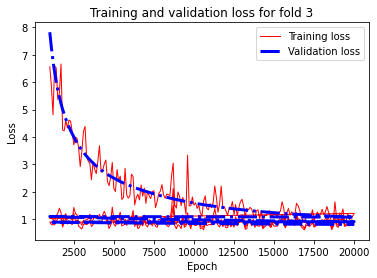

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.81423265, Final Validation loss: 0.80795014, RMSE: 0.89886045 
-----------------------------------------------------------------------


Fold 4:
Epoch: 1000, Training loss: 0.83367264, Validation loss: 0.7631605, 
Epoch: 2000, Training loss: 0.9579354, Validation loss: 0.7608294, 
Epoch: 3000, Training loss: 0.599803, Validation loss: 0.7582728, 
Epoch: 4000, Training loss: 0.83769053, Validation loss: 0.755069, 
Epoch: 5000, Training loss: 0.73847365, Validation loss: 0.75359356, 
Epoch: 6000, Training loss: 0.8781052, Validation loss: 0.75149167, 
Epoch: 7000, Training loss: 0.76685387, Validation loss: 0.7496574, 
Epoch: 8000, Training loss: 0.7782731, Validation loss: 0.7477732, 
Epoch: 9000, Training loss: 0.73150885, Validation loss: 0.7446483, 
Epoch: 10000, Training loss: 0.73719406, Validation loss: 0.743305, 
Epoch: 11000, Training loss: 0.76190674, Validation loss: 0.7414144, 
Epoch: 12000, Training loss: 0.6308836, Validation loss: 0.73981684, 
Epoch:

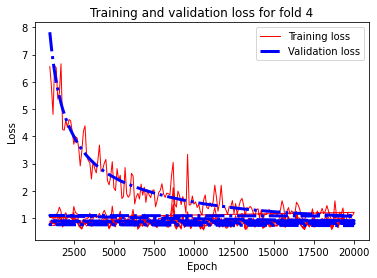

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.78119415, Final Validation loss: 0.72679174, RMSE: 0.8525208 
-----------------------------------------------------------------------


Fold 5:
Epoch: 1000, Training loss: 0.8007051, Validation loss: 0.7255811, 
Epoch: 2000, Training loss: 0.9096538, Validation loss: 0.72690594, 
Epoch: 3000, Training loss: 0.5748223, Validation loss: 0.7235047, 
Epoch: 4000, Training loss: 0.8059199, Validation loss: 0.7223616, 
Epoch: 5000, Training loss: 0.7015994, Validation loss: 0.72005033, 
Epoch: 6000, Training loss: 0.8378638, Validation loss: 0.71824104, 
Epoch: 7000, Training loss: 0.7520369, Validation loss: 0.7195623, 
Epoch: 8000, Training loss: 0.74620616, Validation loss: 0.71621996, 
Epoch: 9000, Training loss: 0.6956712, Validation loss: 0.71512103, 
Epoch: 10000, Training loss: 0.70788085, Validation loss: 0.7131369, 
Epoch: 11000, Training loss: 0.7361616, Validation loss: 0.7109597, 
Epoch: 12000, Training loss: 0.5982483, Validation loss: 0.7122347, 
Epoch: 

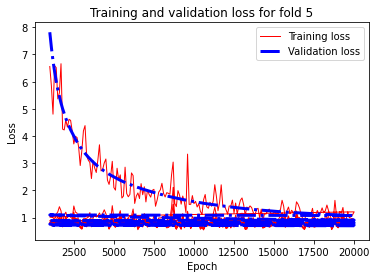

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.7603316, Final Validation loss: 0.70116657, RMSE: 0.8373569 
-----------------------------------------------------------------------


Fold 6:
Epoch: 1000, Training loss: 0.7765929, Validation loss: 0.72064996, 
Epoch: 2000, Training loss: 0.8737238, Validation loss: 0.7193233, 
Epoch: 3000, Training loss: 0.5560642, Validation loss: 0.7181731, 
Epoch: 4000, Training loss: 0.78917235, Validation loss: 0.71784186, 
Epoch: 5000, Training loss: 0.6730256, Validation loss: 0.7164067, 
Epoch: 6000, Training loss: 0.80935717, Validation loss: 0.7156518, 
Epoch: 7000, Training loss: 0.74258333, Validation loss: 0.7146623, 
Epoch: 8000, Training loss: 0.72581255, Validation loss: 0.71350574, 
Epoch: 9000, Training loss: 0.6714396, Validation loss: 0.7129482, 
Epoch: 10000, Training loss: 0.68997383, Validation loss: 0.7117588, 
Epoch: 11000, Training loss: 0.7194551, Validation loss: 0.71138096, 
Epoch: 12000, Training loss: 0.57757235, Validation loss: 0.70998186, 
Epoc

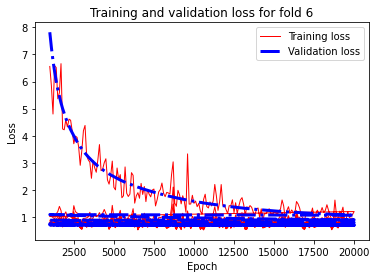

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.74655604, Final Validation loss: 0.7029846, RMSE: 0.8384417 
-----------------------------------------------------------------------


Fold 7:
Epoch: 1000, Training loss: 0.7526727, Validation loss: 0.71076596, 
Epoch: 2000, Training loss: 0.847113, Validation loss: 0.7100566, 
Epoch: 3000, Training loss: 0.5426817, Validation loss: 0.70890325, 
Epoch: 4000, Training loss: 0.7760358, Validation loss: 0.70904136, 
Epoch: 5000, Training loss: 0.64991015, Validation loss: 0.70752877, 
Epoch: 6000, Training loss: 0.7894316, Validation loss: 0.70685613, 
Epoch: 7000, Training loss: 0.73646367, Validation loss: 0.7063376, 
Epoch: 8000, Training loss: 0.71118706, Validation loss: 0.7052048, 
Epoch: 9000, Training loss: 0.6565726, Validation loss: 0.7051676, 
Epoch: 10000, Training loss: 0.6736914, Validation loss: 0.7039703, 
Epoch: 11000, Training loss: 0.70677495, Validation loss: 0.70360845, 
Epoch: 12000, Training loss: 0.56244624, Validation loss: 0.70265764, 
Epoc

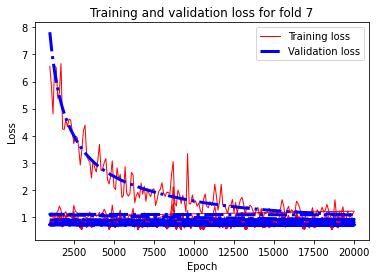

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.73593587, Final Validation loss: 0.6970735, RMSE: 0.83490926 
-----------------------------------------------------------------------


Fold 8:
Epoch: 1000, Training loss: 0.7341337, Validation loss: 0.67844266, 
Epoch: 2000, Training loss: 0.8260955, Validation loss: 0.6780279, 
Epoch: 3000, Training loss: 0.53173953, Validation loss: 0.6771529, 
Epoch: 4000, Training loss: 0.76728094, Validation loss: 0.6760096, 
Epoch: 5000, Training loss: 0.6350879, Validation loss: 0.6752633, 
Epoch: 6000, Training loss: 0.77288264, Validation loss: 0.6745831, 
Epoch: 7000, Training loss: 0.72456884, Validation loss: 0.67427075, 
Epoch: 8000, Training loss: 0.6980173, Validation loss: 0.6735913, 
Epoch: 9000, Training loss: 0.6448742, Validation loss: 0.6722455, 
Epoch: 10000, Training loss: 0.65887827, Validation loss: 0.6715126, 
Epoch: 11000, Training loss: 0.6993097, Validation loss: 0.6708288, 
Epoch: 12000, Training loss: 0.54984736, Validation loss: 0.67031527, 
Epoch

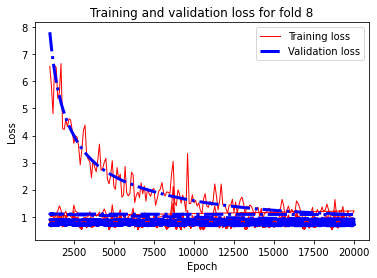

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.72586757, Final Validation loss: 0.66435367, RMSE: 0.8150789 
-----------------------------------------------------------------------


Fold 9:
Epoch: 1000, Training loss: 0.70864165, Validation loss: 0.6597756, 
Epoch: 2000, Training loss: 0.80900365, Validation loss: 0.65977365, 
Epoch: 3000, Training loss: 0.5225992, Validation loss: 0.6586312, 
Epoch: 4000, Training loss: 0.7621515, Validation loss: 0.6582005, 
Epoch: 5000, Training loss: 0.6224443, Validation loss: 0.6570679, 
Epoch: 6000, Training loss: 0.7598152, Validation loss: 0.6565111, 
Epoch: 7000, Training loss: 0.7098659, Validation loss: 0.6566613, 
Epoch: 8000, Training loss: 0.68359447, Validation loss: 0.65552145, 
Epoch: 9000, Training loss: 0.63161314, Validation loss: 0.65490913, 
Epoch: 10000, Training loss: 0.64590657, Validation loss: 0.6539516, 
Epoch: 11000, Training loss: 0.6933137, Validation loss: 0.6534608, 
Epoch: 12000, Training loss: 0.5401654, Validation loss: 0.6533761, 
Epoch:

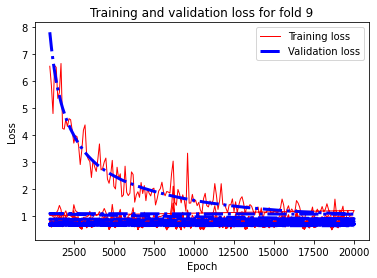

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.7131367, Final Validation loss: 0.64823306, RMSE: 0.80512923 
-----------------------------------------------------------------------


Fold 10:
Epoch: 1000, Training loss: 0.6868633, Validation loss: 0.66989005, 
Epoch: 2000, Training loss: 0.795018, Validation loss: 0.6690648, 
Epoch: 3000, Training loss: 0.51360714, Validation loss: 0.66854364, 
Epoch: 4000, Training loss: 0.7578013, Validation loss: 0.6690329, 
Epoch: 5000, Training loss: 0.6115081, Validation loss: 0.66766375, 
Epoch: 6000, Training loss: 0.7390684, Validation loss: 0.66719025, 
Epoch: 7000, Training loss: 0.69720733, Validation loss: 0.6663822, 
Epoch: 8000, Training loss: 0.67271185, Validation loss: 0.66581523, 
Epoch: 9000, Training loss: 0.6211696, Validation loss: 0.6661279, 
Epoch: 10000, Training loss: 0.63385, Validation loss: 0.66510934, 
Epoch: 11000, Training loss: 0.6882616, Validation loss: 0.6649873, 
Epoch: 12000, Training loss: 0.53273726, Validation loss: 0.66377175, 
Epoch

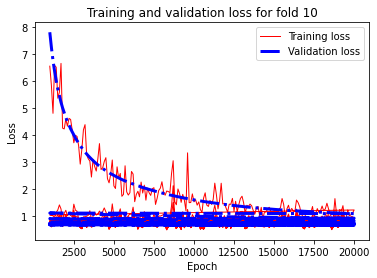

<Figure size 432x288 with 0 Axes>

Final Training loss: 0.7020292, Final Validation loss: 0.6601109, RMSE: 0.8124721 
-----------------------------------------------------------------------


Average Validation RMSE for the 10 folds: 0.8685424 




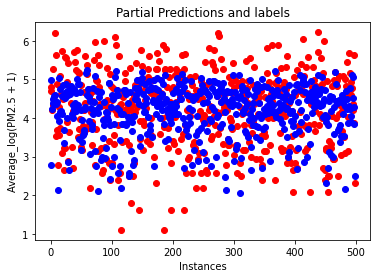

Average Test RMSE: 0.80326694


In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

train_x = []
test_x = []
train_y = []
test_y = []
# record the train losses for every 1000 epochs for a certain model
train_losses = []
# record the validate losses for every 1000 epochs for a certain model
val_losses = []
select_epoch_from = 1000
epochs = []
batch_iteration = 0
fold = 0
train_loss = 0
val_loss = 0
# record the train losses for the total 10 fold models
#kfold_train_losses = []
# record the validate losses for the total 10 fold models
kfold_val_losses = []

with tf.Session() as sess: 
    sess.run(init)
    start_time = time.clock() 
    for train_index, val_index in kf.split(X_train, y_train):

        fold = fold + 1
        print("Fold %s:" % (fold))
        train_x = X_train[train_index]
        train_y = y_train[train_index]
  
        val_x = X_train[val_index]
        val_y = y_train[val_index]

        batch_iteration = int(len(train_x) / batch_size) + 1

        for epoch in range(1,number_epochs+1):
          
            n = epoch % batch_iteration
            s = 0 + batch_size * n
            if n == 0:
               e = len(train_x)
            else:
               e = batch_size + batch_size * n
            
            batch_X = np.array(X_train[s:e])
            batch_y = np.array(y_train[s:e])

            _, train_loss = sess.run([optimizer, loss_func], feed_dict={X_p: batch_X, Y_p: batch_y})
            val_loss = loss_func.eval({X_p: val_x, Y_p: val_y})

            if epoch >= select_epoch_from and epoch % 100 == 0:
               train_losses.append(train_loss)
               val_losses.append(val_loss)
               epochs.append(epoch)

            #Display the epoch
            if epoch % 1000 == 0:
               print("Epoch: %d, "
                     "Training loss: %s, "
                     "Validation loss: %s, " % (epoch, train_loss, val_loss))

        end_time = time.clock()
        print("The total training time is: " + str(end_time-start_time))

        pyplot.plot(epochs, train_losses, 'r', label='Training loss', linewidth=1, linestyle='-')
        pyplot.plot(epochs, val_losses, 'b', label='Validation loss', linewidth=3, linestyle='-.')
        pyplot.xlabel('Epoch') 
        pyplot.ylabel('Loss')
        pyplot.title('Training and validation loss for fold %s' % (fold))
        pyplot.legend()
        pyplot.figure()
        pyplot.show()
        kfold_RMSE = np.sqrt(val_loss)
        print("Final Training loss: %s, "
              "Final Validation loss: %s, " 
              "RMSE: %s "% (train_loss, val_loss, kfold_RMSE )) 
        print("-----------------------------------------------------------------------\n\n")
        #kfold_train_losses.append(kfold_RMSE)
        kfold_val_losses.append(kfold_RMSE)
  
    # average train RMSE for the 10 folds
   # average_train_rmse_score_10fold = np.sqrt(np.mean(kfold_train_losses))

    # average validate RMSE for the 10 folds
    average_val_rmse_score_10fold = np.mean(kfold_val_losses)

    #print("Average Train RMSE for the 10 folds: %s \n" % str(average_train_rmse_score_10fold))
    print("Average Validation RMSE for the 10 folds: %s \n\n" % str(average_val_rmse_score_10fold))


    # Test model
    pred = (neural_network) 
    output=neural_network.eval({X_p: X_test}) 

    # plot prediction and labels
    pyplot.plot(y_test[0:500], 'ro', label='Testing labels')
    pyplot.plot(output[0:500], 'bo', label='Predictions')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Average_log(PM2.5 + 1)')
    pyplot.title('Partial Predictions and labels')
    pyplot.show()

    # final RMSE
    rmse_score = sess.run(eval_RMSE,feed_dict={X_p:X_test,Y_p:y_test})
    print("Average Test RMSE: " + str(rmse_score))
